In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10
numpyro.set_host_device_count(n_chains)

In [5]:
seed = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def full_solution(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    return dmeq.solve(p, dtype=jnp.float64)

In [7]:
population = 1_000_000
prev_N = 1_000

def prev_stats(params, eir, eta):
    solution = full_solution(params, eir, eta)
    inc_rates = solution[1] * solution[-1] * population
    return (
        jnp.array([
            solution[0, 3:10].sum() / solution[-1, 3:10].sum(), # Prev 2 - 10
            solution[0, 10:].sum() / solution[-1, 10:].sum(), # Prev 10+
        ]),
        jnp.array([
            inc_rates[:5].sum(), # Inc 0 - 5
            inc_rates[5:15].sum(), # Inc 5 - 15
            inc_rates[15:].sum() # Inc 15+
        ])
    )

In [8]:
def prev_stats_multisite(params, eirs, etas):
    return vmap(prev_stats, in_axes=[None, 0, 0])(params, eirs, etas)

In [9]:
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
etas = 1. / (random.normal(seed, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [18]:
def model(prev=None, inc=None):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.LogNormal(0., .25))
    ub = numpyro.sample('ub', dist.LogNormal(0., .25))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=0.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.LogNormal(0., .25))
    uc = numpyro.sample('uc', dist.LogNormal(0., .25))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Cauchy(100., 10.), low=0.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Cauchy(200., 10.), low=0.))
    
    # Detection immunity
    kd = numpyro.sample('kd', dist.LogNormal(0., .25))
    ud = numpyro.sample('ud', dist.LogNormal(0., .25))
    d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Cauchy(25., 1.), low=0.))
    fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
    gd = numpyro.sample('gd', dist.LogNormal(0., .25))
    ad0 = numpyro.sample('ad0', dist.LeftTruncatedDistribution(dist.Cauchy(10., 1.), low=0.))
    
    du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Cauchy(50., 1.), low=0.))
    
    # FOIM
    cd = numpyro.sample('cd', dist.Beta(1., 2.))
    cu = numpyro.sample('cu', dist.Beta(1., 5.))
    g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    prev_stats, inc_stats = prev_stats_multisite({
        'kb': kb,
        'ub': ub,
        'b0': b0,
        'IB0': IB0,
        'kc': kc,
        'uc': uc,
        'IC0': IC0,
        'phi0': phi0,
        'phi1': phi1,
        'PM': PM,
        'dm': dm,
        'kd': kd,
        'ud': ud,
        'd1': d1,
        'ID0': ID0,
        'fd0': fd0,
        'gd': gd,
        'ad0': ad0,
        'rU': 1. / du,
        'cd': cd,
        'cu': cu,
        'g_inf': g_inf
    }, EIRs, etas)
    
    numpyro.sample(
        'obs_prev',
        dist.Independent(
            dist.Binomial(total_count=prev_N, probs=prev_stats),
            1
        ),
        obs=prev
    )
    numpyro.sample(
        'obs_inc',
        dist.Independent(
            dist.Poisson(rate=inc_stats),
            1
        ),
        obs=inc
    )

In [19]:
true_values = Predictive(model, num_samples=1)(seed)

In [20]:
true_values

{'IB0': Array([55.93777004], dtype=float64),
 'IC0': Array([93.45644582], dtype=float64),
 'ID0': Array([26.76162768], dtype=float64),
 'PM': Array([0.61014955], dtype=float64),
 'ad0': Array([8.85446573], dtype=float64),
 'b0': Array([0.35407383], dtype=float64),
 'cd': Array([0.68705994], dtype=float64),
 'cu': Array([0.10249611], dtype=float64),
 'd1': Array([0.16219049], dtype=float64),
 'dm': Array([202.28734477], dtype=float64),
 'du': Array([49.0816466], dtype=float64),
 'fd0': Array([0.63126972], dtype=float64),
 'g_inf': Array([3.84335058], dtype=float64),
 'gd': Array([1.00200147], dtype=float64),
 'kb': Array([1.53182605], dtype=float64),
 'kc': Array([0.7970634], dtype=float64),
 'kd': Array([1.26013222], dtype=float64),
 'obs_inc': Array([[[  0,   1,   1],
         [  5,  15,   3],
         [ 40,  37,  29],
         [ 36,  50,  36],
         [ 95, 129,  77],
         [126, 162, 121],
         [343, 397, 193]]], dtype=int64),
 'obs_prev': Array([[[  8,   4],
         [139, 

In [21]:
obs_inc, obs_prev = (true_values['obs_inc'], true_values['obs_prev'])

In [22]:
prior = Predictive(model, num_samples=600)(seed)

In [23]:
def get_curves(params, eirs, etas):
    return vmap(
        vmap(
            full_solution,
            in_axes=[
                {k: 0 for k in params.keys()},
                None,
                None
            ]
        ),
        in_axes=[None, 0, 0]
    )(params, eirs, etas)

def without_obs(params):
    return {k : v for k, v in params.items() if not k in {'obs_inc', 'obs_prev'}}
prior_curves = get_curves(without_obs(prior), EIRs, etas)
true_curves = get_curves(without_obs(true_values), EIRs, etas)

Text(0.5, 1, 'Prior immunity probability function')

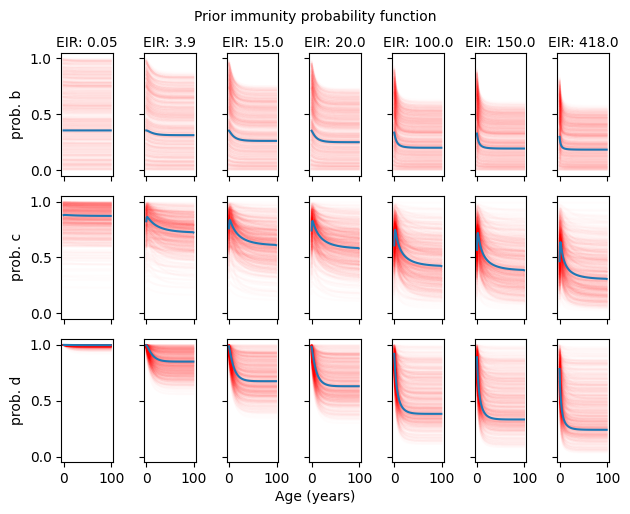

In [24]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(prior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior immunity probability function', ha='center')

Text(0.5, 1, 'Prior pos_M/inc function')

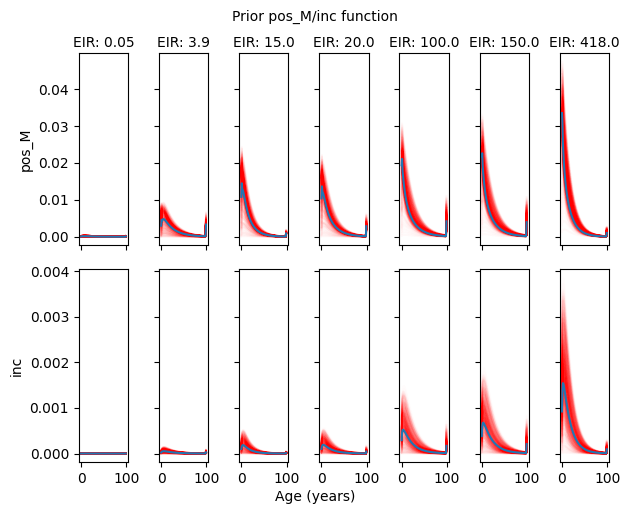

In [25]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}',
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(prior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior pos_M/inc function', ha='center')

In [26]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(seed, obs_prev, obs_inc)
mcmc.print_summary(prob=0.7)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     49.99      9.57     49.79     39.69     59.82   1047.58      1.01
       IC0     95.98     20.04     97.92     85.57    116.31   1070.54      1.00
       ID0     24.95      1.63     24.95     23.79     26.18    648.11      1.01
        PM      0.50      0.28      0.50      0.26      0.90   1906.51      0.99
       ad0     11.02     11.52     10.01      7.97     12.08    386.13      1.02
        b0      0.45      0.05      0.44      0.39      0.49    735.19      1.01
        cd      0.32      0.23      0.28      0.00      0.44   1358.87      1.00
        cu      0.17      0.14      0.14      0.00      0.22   1137.62      1.00
        d1      0.15      0.03      0.15      0.13      0.19    544.88      1.01
        dm    192.32     38.05    198.27    176.42    219.67     86.63      1.15
        du     50.60     10.05     50.05     47.74     52.64    288.86      1.01
       fd0      0.51      0

In [28]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(seed, obs_prev, obs_inc)

In [29]:
from numpyro.diagnostics import summary
import pandas as pd
d = pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()
d['true_value'] = pd.Series(without_obs(true_values)).apply(lambda x: x[0]).astype(float)
print(d.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   mean &   std &  median &  15.0\% &  85.0\% &   n\_eff &  r\_hat &  true\_value \\
\midrule
IB0   &  49.99 &  9.57 &   49.79 &  39.69 &  59.82 & 1047.58 &   1.01 &       55.94 \\
IC0   &  95.98 & 20.04 &   97.92 &  85.57 & 116.31 & 1070.54 &   1.00 &       93.46 \\
ID0   &  24.95 &  1.63 &   24.95 &  23.79 &  26.18 &  648.11 &   1.01 &       26.76 \\
PM    &   0.50 &  0.28 &    0.50 &   0.26 &   0.90 & 1906.51 &   0.99 &        0.61 \\
ad0   &  11.02 & 11.52 &   10.01 &   7.97 &  12.08 &  386.13 &   1.02 &        8.85 \\
b0    &   0.45 &  0.05 &    0.44 &   0.39 &   0.49 &  735.19 &   1.01 &        0.35 \\
cd    &   0.32 &  0.23 &    0.28 &   0.00 &   0.44 & 1358.87 &   1.00 &        0.69 \\
cu    &   0.17 &  0.14 &    0.14 &   0.00 &   0.22 & 1137.62 &   1.00 &        0.10 \\
d1    &   0.15 &  0.03 &    0.15 &   0.13 &   0.19 &  544.88 &   1.01 &        0.16 \\
dm    & 192.32 & 38.05 &  198.27 & 176.42 & 219.67 &   86.63 &   1.15 &      202.29

/tmp/ipykernel_98268/2922237432.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(d.to_latex(float_format="{:0.2f}".format))


In [30]:
posterior_curves = get_curves(posterior_samples, EIRs, etas)

Text(0.5, 1, 'Posterior immunity probability function')

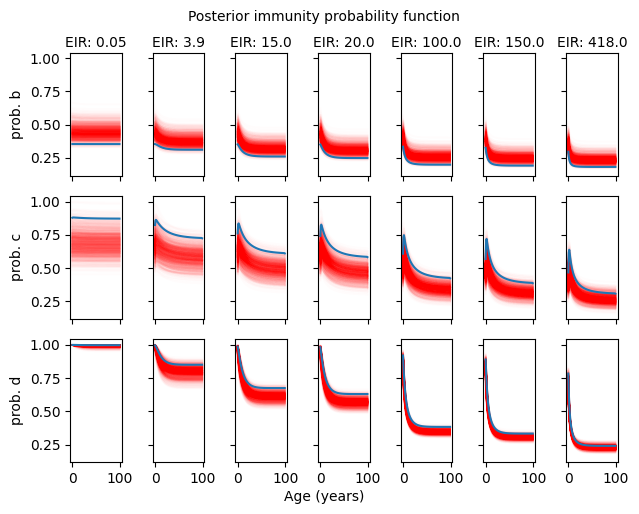

In [31]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

Text(0.5, 1, 'Posterior pos_M/inc function')

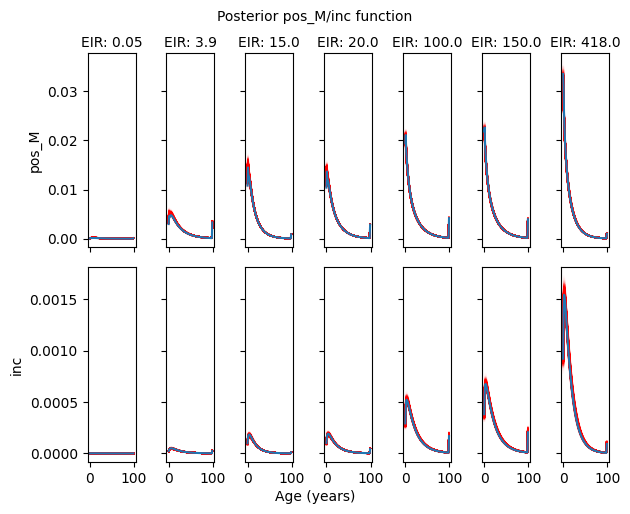

In [32]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}'
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        #axs[prev, 0].set_yscale('log')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

In [33]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

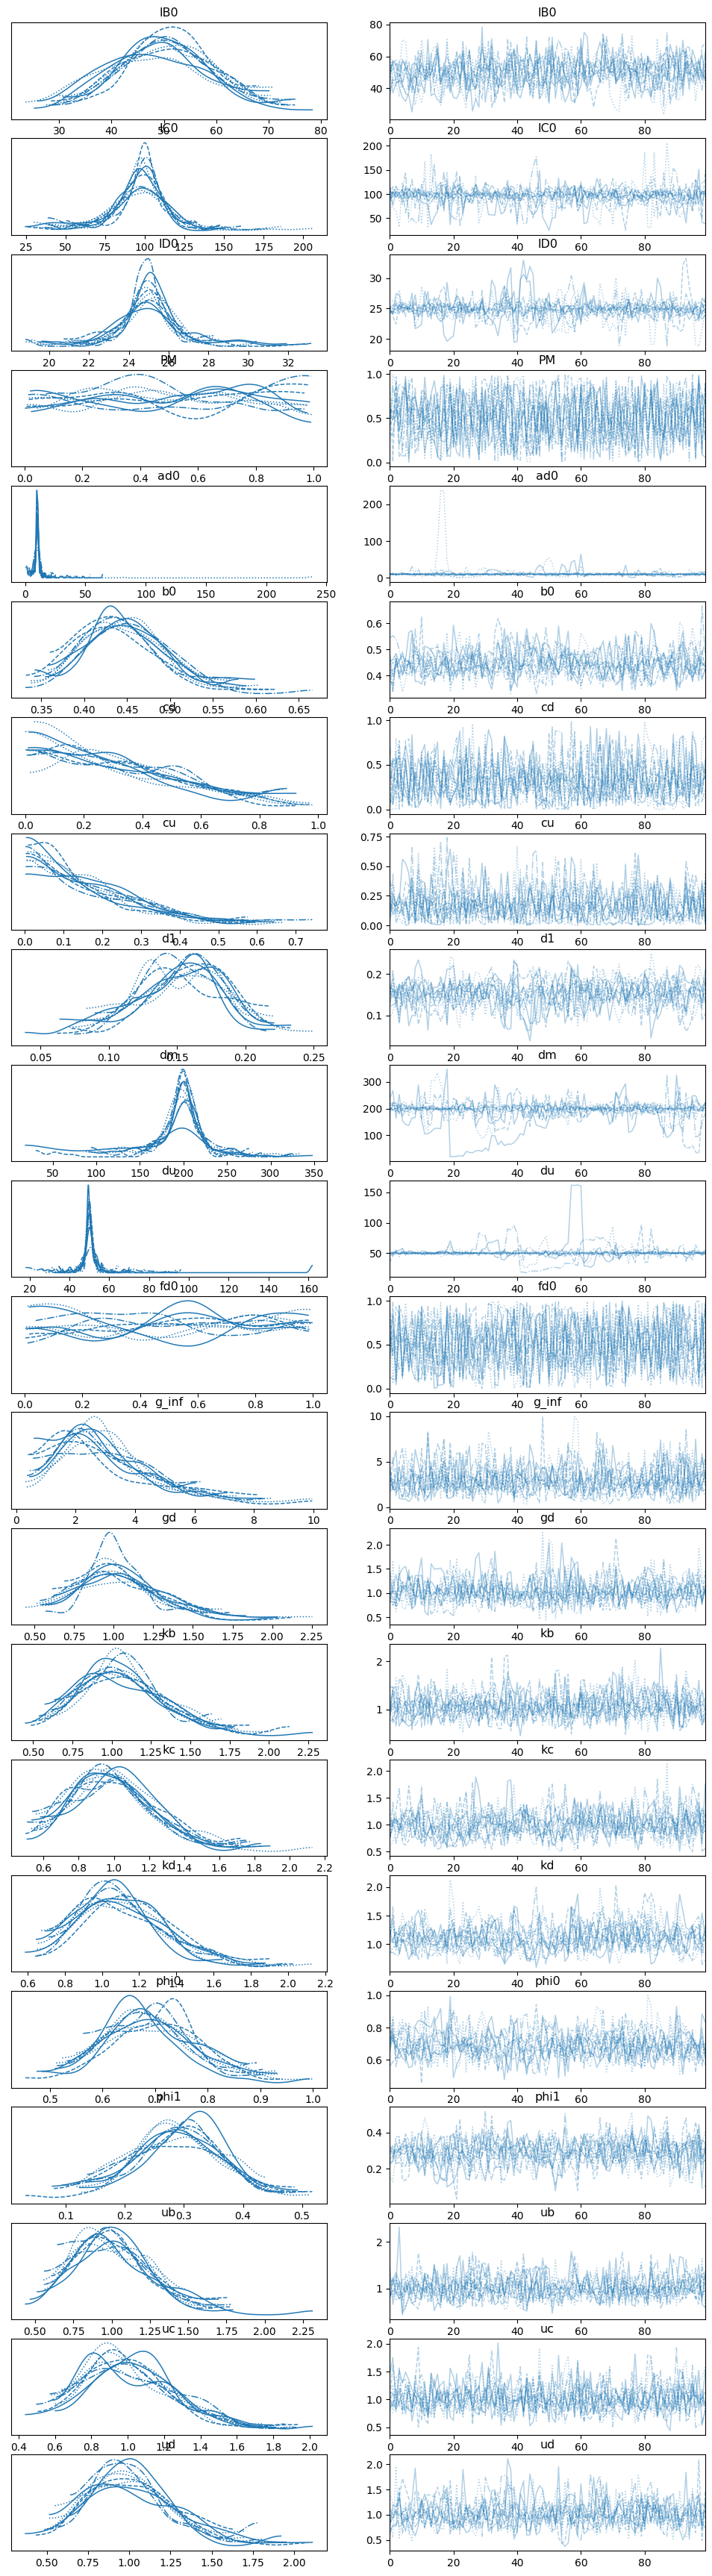

In [34]:
az.rcParams["plot.max_subplots"] = 200
axs = az.plot_trace(pyro_data)

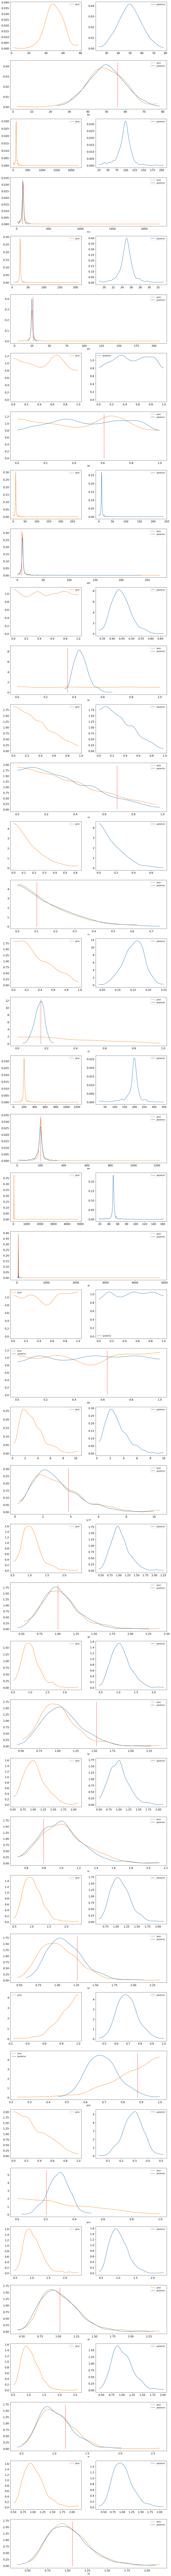

In [35]:
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )

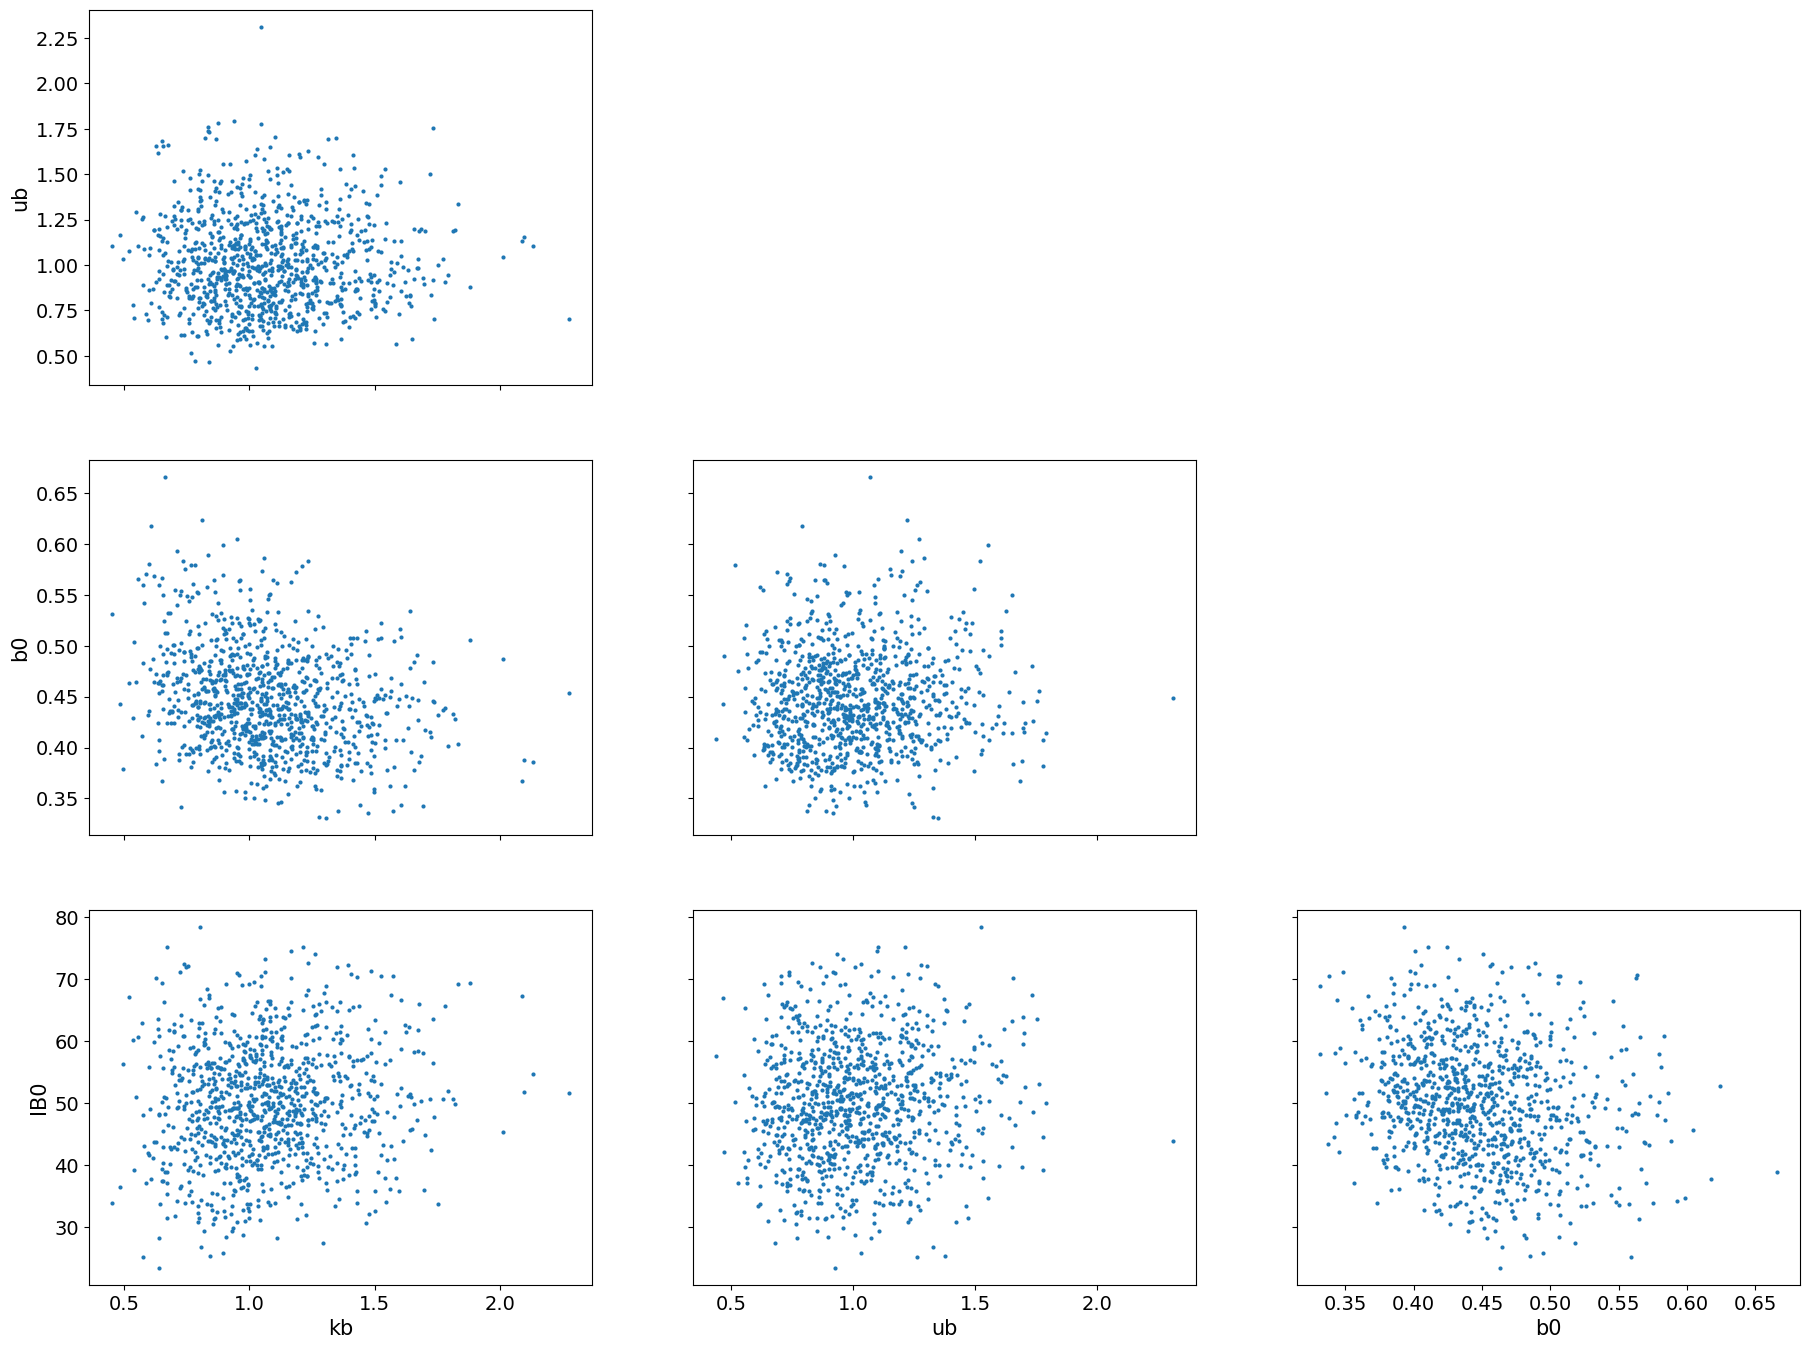

In [36]:
ax = az.plot_pair(
    pyro_data,
    var_names=[
        'kb',
        'ub',
        'b0',
        'IB0'
    ]
)

array([[<AxesSubplot: ylabel='uc'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='IC0'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='phi0'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='kc', ylabel='phi1'>,
        <AxesSubplot: xlabel='uc'>, <AxesSubplot: xlabel='IC0'>,
        <AxesSubplot: xlabel='phi0'>]], dtype=object)

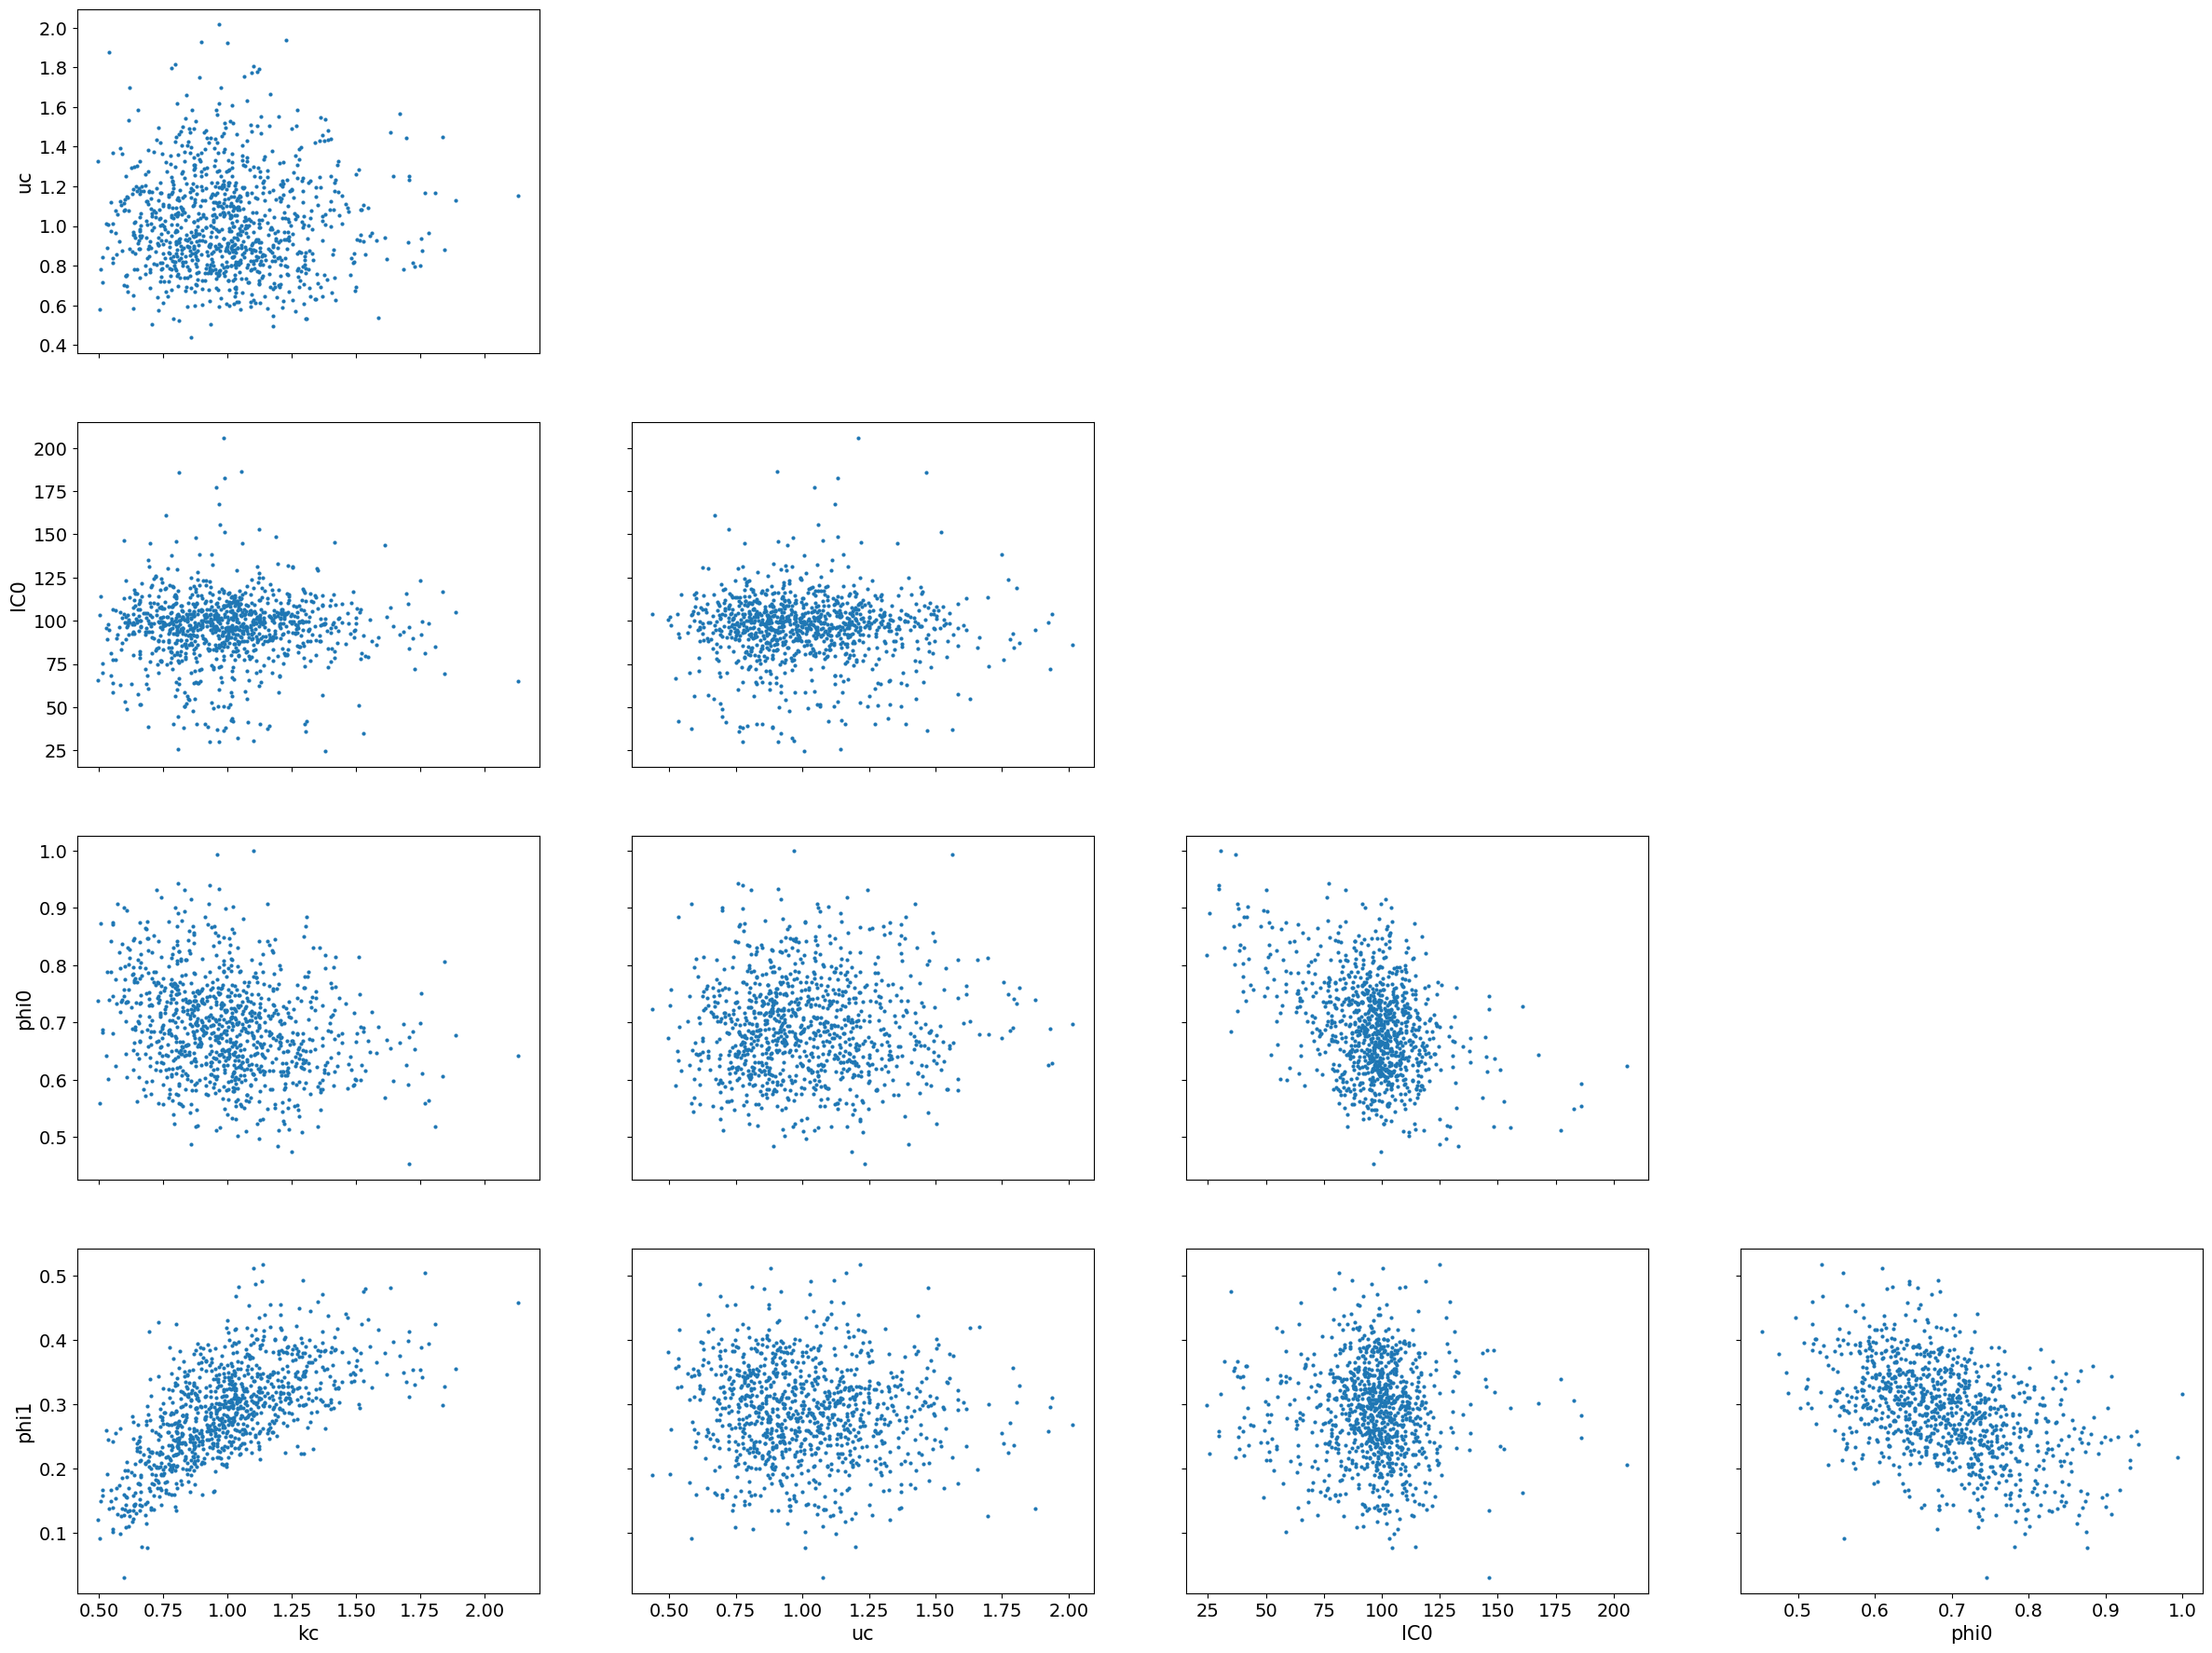

In [37]:
az.plot_pair(
    pyro_data,
    var_names=[
        'kc',
        'uc',
        'IC0',
        'phi0',
        'phi1',
        #'PM',
        #'dm'
    ]
)

array([[<AxesSubplot: ylabel='ud'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='d1'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='ID0'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='kd', ylabel='fd0'>,
        <AxesSubplot: xlabel='ud'>, <AxesSubplot: xlabel='d1'>,
        <AxesSubplot: xlabel='ID0'>]], dtype=object)

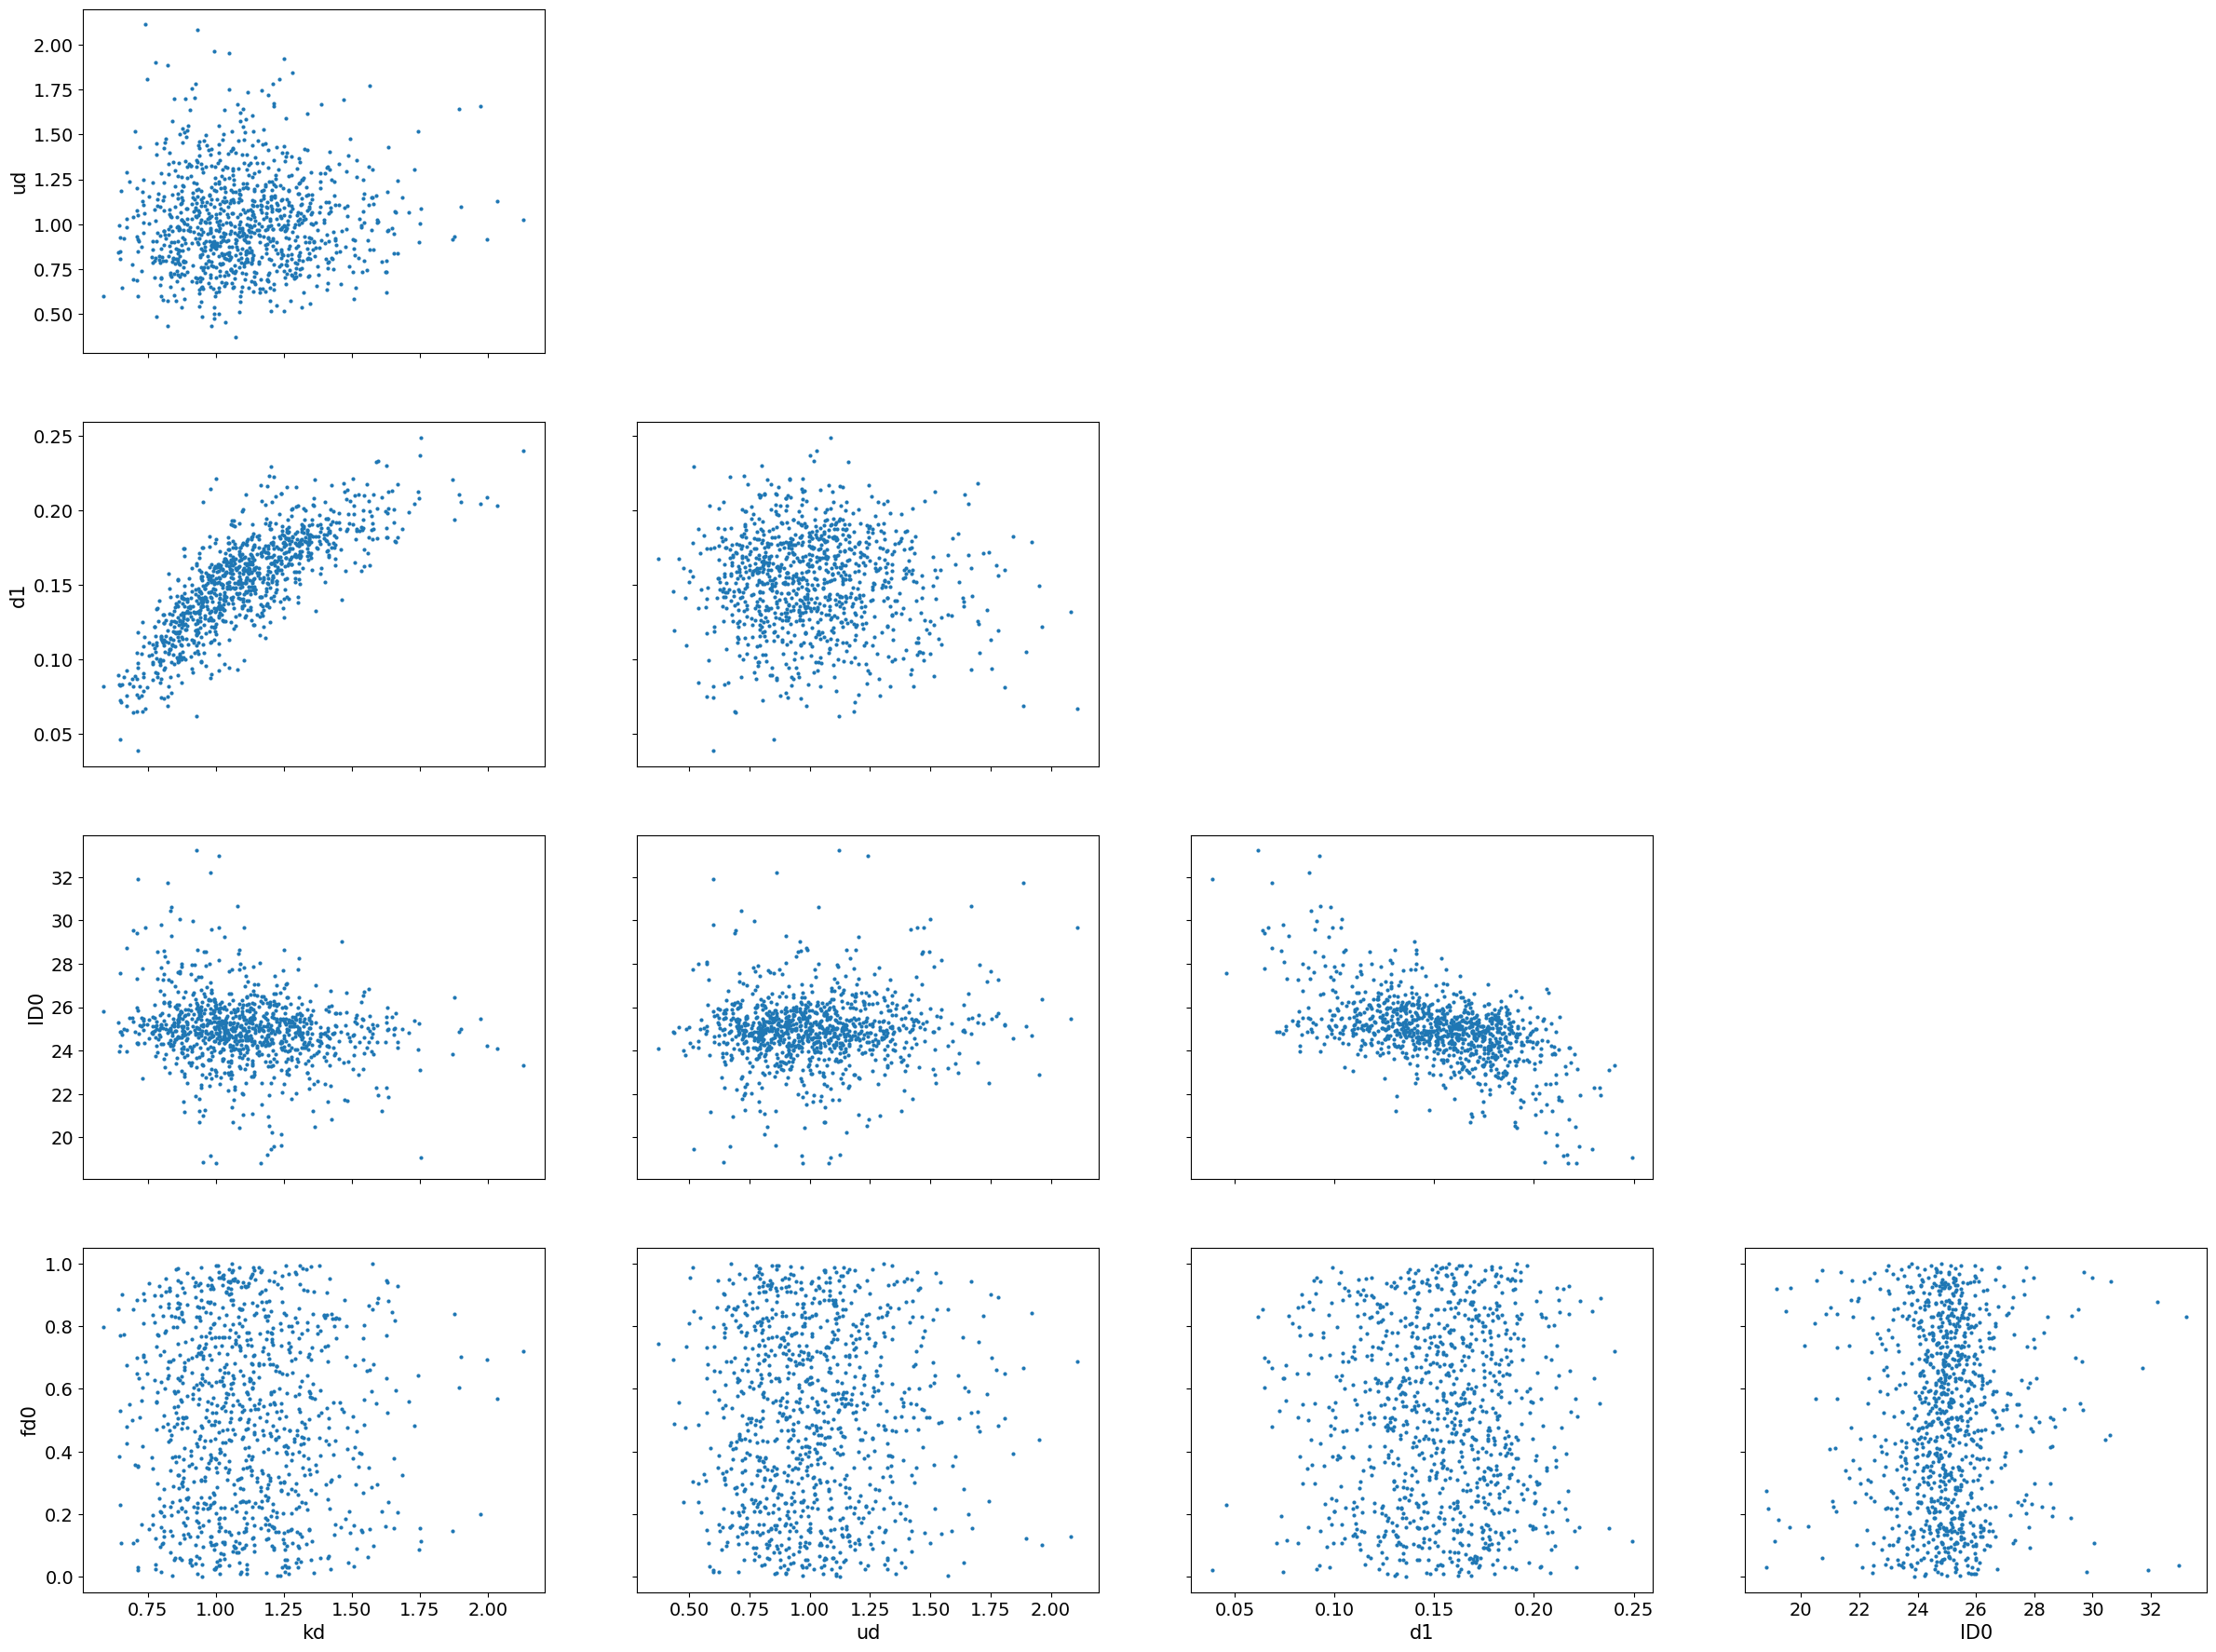

In [38]:
az.plot_pair(
    pyro_data,
    var_names=[
        'kd',
        'ud',
        'd1',
        'ID0',
        'fd0',
        #'gd',
        #'ad0',
        # 'du'
    ]
)

array([[<AxesSubplot: ylabel='cu'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='cd', ylabel='g_inf'>,
        <AxesSubplot: xlabel='cu'>]], dtype=object)

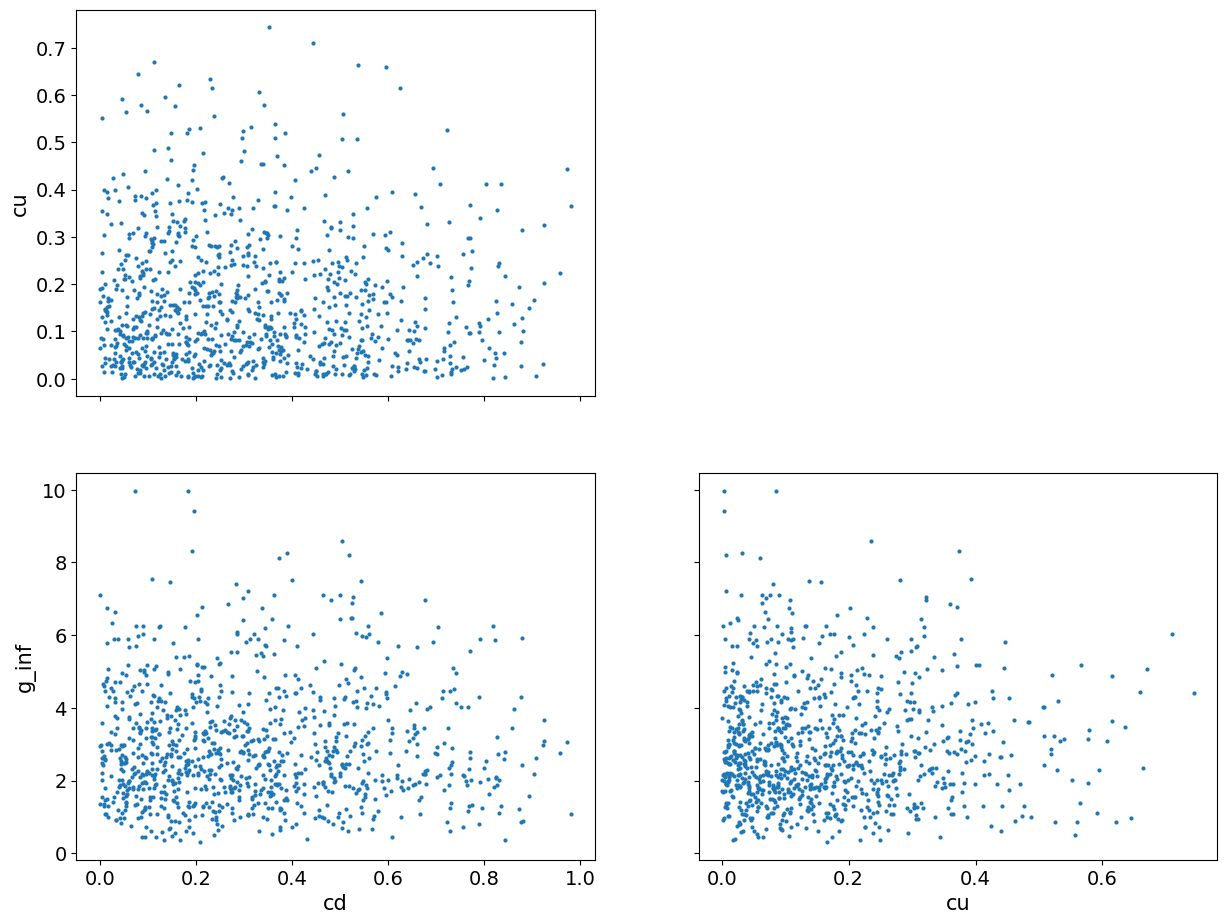

In [39]:
az.plot_pair(
    pyro_data,
    var_names=[
        'cd',
        'cu',
        'g_inf'
    ]
)